# 实验十：SVD与协同过滤推荐系统

In [1]:
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt

In [2]:
def loadExData():
    return[[2, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
            [3, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
            [5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
            [4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
            [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
            [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
            [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0],
            [1, 1, 2, 1, 1, 2, 1, 0, 4, 5, 0]]

In [3]:
myMat = mat(loadExData()) # np.mat将数值转为matrix，相比于通用的np.array数据结构，可以进行更快的矩阵运算（我感觉没有区别）

## 1. 基于numpy实现SVD

In [4]:
# 数据是一个方阵，SVD可以将任意 m x n 的矩阵分解成三个矩阵的乘积
# 同学们可以自己输入非方阵数据，观察结果
print(f'原始矩阵的大小: {myMat.shape}')
print(f'原始矩阵的秩: {la.matrix_rank(myMat)}')

原始矩阵的大小: (11, 11)
原始矩阵的秩: 10


In [5]:
# np.linalg.svd
# 感兴趣的同学可以自己实现一个SVD函数
U, Sigma, VT = linalg.svd(myMat)

In [6]:
print(U.shape) # m x m 的正交矩阵
print(f'U矩阵的秩: {la.matrix_rank(U)}') #行满秩
print(VT.shape) # n x n 的正交矩阵
print(f'V矩阵的秩: {la.matrix_rank(VT)}') #列满秩

(11, 11)
U矩阵的秩: 11
(11, 11)
V矩阵的秩: 11


In [7]:
Sigma  # np.linalg.svd返回会自动对奇异值排序，U、V的特征向量也依此排序

array([1.34342819e+01, 1.18190832e+01, 8.20176076e+00, 6.86912480e+00,
       5.29063022e+00, 3.91213561e+00, 2.94562509e+00, 2.35486137e+00,
       2.08702082e+00, 7.08715931e-01, 1.73668705e-16])

In [35]:
# Sigma中最后两个奇异值偏小，尝试去除后重构一个新的矩阵
dropnum = 10
new_Sigma = Sigma[:len(Sigma)-dropnum]
new_Sigma_matrix = diag(new_Sigma)
new_myMat = U[:,:len(Sigma)-dropnum] * new_Sigma_matrix * VT[:len(Sigma)-dropnum,:]

In [36]:
# 重构后的新矩阵的大小不变，但是总能量减少
print(f'新矩阵的大小: {new_myMat.shape}')
print(f'新矩阵的秩: {la.matrix_rank(new_myMat)}')

新矩阵的大小: (11, 11)
新矩阵的秩: 1


旧矩阵和新矩阵在剔除最后两个奇异值下的热图视觉观感相似

请同学们修改dropnum，查看不同值对结果的影响

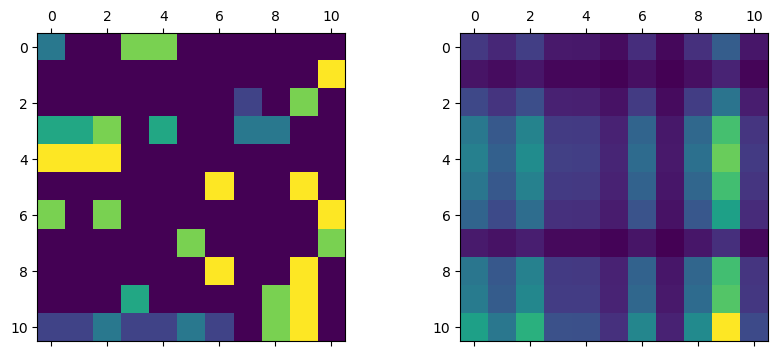

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.matshow(myMat)
ax2.matshow(new_myMat)

## 2. 相似性度量方法

#### 欧式距离

In [11]:
def ecludSim(inA, inB):
    """
    欧式距离相似度：
    距离越小，相似度越大，范围 (0, 1]。
    """
    return 1.0 / (1.0 + la.norm(inA - inB))

#### 余弦相似度

In [12]:
def cosSim(inA, inB):
    """
    余弦相似度：
    cos(theta) = (A·B) / (||A|| * ||B||)，再缩放到 [0, 1] 区间。
    """
    num = float(inA.T * inB)
    denom = la.norm(inA) * la.norm(inB)
    if denom == 0:
        return 0.0
    return 0.5 + 0.5 * (num / denom)


#### 皮尔逊相关系数

In [13]:
def pearsSim(inA, inB):
    """
    皮尔逊相关系数：
    corr(A, B) ∈ [-1, 1]，再缩放到 [0, 1]。
    """
    # 样本太少时，相关系数不稳定，直接返回相似度 1.0
    if len(inA) < 3:
        return 1.0

    a = array(inA).flatten()
    b = array(inB).flatten()

    # 一方标准差为 0 时，相关系数为 NaN，同样直接认为相似度较高
    if a.std() == 0 or b.std() == 0:
        return 1.0

    return 0.5 + 0.5 * corrcoef(a, b)[0][1]


## 3. 餐馆菜肴推荐系统

In [14]:
def standEst(dataMat, user, simMeas, item):
    n = shape(dataMat)[1]
    simTotal = 0.0
    ratSimTotal = 0.0
    for j in range(n):
        userRating = dataMat[user, j]
        if userRating == 0:
            continue
        overLap = nonzero(logical_and(dataMat[:, item].A > 0, dataMat[:, j].A > 0))[0]
        if len(overLap) == 0:
            similarity = 0
        else:
            similarity = simMeas(dataMat[overLap, item], dataMat[overLap, j])
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0:
        return 0
    else:
        return ratSimTotal/simTotal

In [15]:
def svdEst(dataMat, user, simMeas, item):
    n = shape(dataMat)[1]
    simTotal = 0.0
    ratSimTotal = 0.0
    U, Sigma, VT = la.svd(dataMat)
    Sig4 = mat(eye(top) * Sigma[: top])  # top具体是多少将在后面分析（非规范代码写法）
    xformedItems = dataMat.T * U[:, :top] * Sig4.I  # dataMat.T * U[:, :top] * Sig4.I == VT[:top,:].T
    for j in range(n):
        userRating = dataMat[user, j]
        if userRating == 0 or j == item:
            continue
        similarity = simMeas(xformedItems[item, :].T, xformedItems[j, :].T)
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0:
        return 0
    else:
        return ratSimTotal/simTotal

In [16]:
def recommend(dataMat, user, N=3, simMeas=ecludSim, estMethod=standEst):
    unratedItems = nonzero(dataMat[user, :].A == 0)[1]
    if len(unratedItems) == 0:
        return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[: N]

In [17]:
# 方式1: 通过欧式距离计算相似度
recommend(myMat, 1, simMeas=ecludSim)

[(0, 5.0), (2, 5.0), (5, 5.0)]

In [18]:
# 方式2: 通过余弦相似度计算相似度
recommend(myMat, 1, simMeas=cosSim)

C:\Users\16477\AppData\Local\Temp\ipykernel_17288\2330496384.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(inA.T * inB)


[(0, 5.0), (2, 5.0), (5, 5.0)]

In [19]:
# 方式3: 通过皮尔逊相关系数计算相似度
recommend(myMat, 1, simMeas=pearsSim)

[(0, 5.0), (2, 5.0), (5, 5.0)]

SVD能量分析

In [20]:
U, Sigma, VT = la.svd(myMat)
print(Sigma)                 # 计算矩阵的SVD来了解其需要多少维的特征

[1.34342819e+01 1.18190832e+01 8.20176076e+00 6.86912480e+00
 5.29063022e+00 3.91213561e+00 2.94562509e+00 2.35486137e+00
 2.08702082e+00 7.08715931e-01 1.73668705e-16]


In [21]:
Sig = Sigma**2
print(f'总能量: {sum(Sig):.2f}')   # 计算总能量

总能量: 497.00


In [22]:
threshold = sum(Sig) * 0.9
print(f'总能量的90%: {threshold:.2f}')  # 计算总能量的90%

总能量的90%: 447.30


In [23]:
# 计算需要多少个奇异值能达到总能量的90%
for i in range(1,len(Sigma)):
    if(sum(Sig[:i]) < threshold):   # 计算前n个元素所包含的能量
        print(f'前{i}个元素所包含的能量：{sum(Sig[:i]):.2f}, 没有到达90%')
    else:
        print(f'前{i}个元素所包含的能量：{sum(Sig[:i]):.2f}, 达到90%')
        break

前1个元素所包含的能量：180.48, 没有到达90%
前2个元素所包含的能量：320.17, 没有到达90%
前3个元素所包含的能量：387.44, 没有到达90%
前4个元素所包含的能量：434.62, 没有到达90%
前5个元素所包含的能量：462.62, 达到90%


In [24]:
# 方式4: 通过SVD对原始矩阵降维，再用欧式距离计算相似度
top = 5
recommend(myMat, 1, simMeas=ecludSim, estMethod=svdEst)

[(0, 5.0), (1, 5.0), (3, 5.0)]

In [25]:
import pandas as pd

# 读取 data.csv；文件和 notebook 在同一路径的话，直接这样写就可以
ratings_df = pd.read_csv('data.csv', header=None, delim_whitespace=True)

print(ratings_df.shape)
ratings_df.head()


(201, 500)


C:\Users\16477\AppData\Local\Temp\ipykernel_17288\1117259413.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ratings_df = pd.read_csv('data.csv', header=None, delim_whitespace=True)


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,490.0,491.0,492.0,493.0,494.0,495.0,496.0,497.0,498.0,499.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [26]:
# 第 0 行是菜品编号，从第 1 行开始才是用户评分
item_ids = ratings_df.iloc[0].values          # 500 个菜品 ID
dataMat = mat(ratings_df.iloc[1:].values)     # 200 x 500 的评分矩阵

print("用户数，菜品数：", dataMat.shape)


用户数，菜品数： (200, 500)


In [27]:
# 选择一个用户（0~199），比如 10 号用户
user = 10

print("=== 使用欧式距离的推荐结果 ===")
recs_euclid = recommend(dataMat, user, simMeas=ecludSim)
print(recs_euclid)

print("=== 使用余弦相似度的推荐结果 ===")
recs_cos = recommend(dataMat, user, simMeas=cosSim)
print(recs_cos)

print("=== 使用皮尔逊相关系数的推荐结果 ===")
recs_pear = recommend(dataMat, user, simMeas=pearsSim)
print(recs_pear)


=== 使用欧式距离的推荐结果 ===
[(124, 4.24), (412, 4.24), (377, 4.228571428571429)]
=== 使用余弦相似度的推荐结果 ===


C:\Users\16477\AppData\Local\Temp\ipykernel_17288\2330496384.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(inA.T * inB)


[(377, 4.222222222222222), (54, 4.166666666666667), (124, 4.142857142857143)]
=== 使用皮尔逊相关系数的推荐结果 ===
[(377, 4.222222222222222), (54, 4.166666666666667), (124, 4.142857142857143)]


In [28]:
def pretty_print_recs(recs, item_ids):
    for idx, score in recs:
        dish_id = int(item_ids[idx])
        print(f"推荐菜品 ID = {dish_id}, 预测评分 = {score:.2f}")

print("=== 欧式距离 推荐菜品 ===")
pretty_print_recs(recs_euclid, item_ids)

print("\n=== 余弦相似度 推荐菜品 ===")
pretty_print_recs(recs_cos, item_ids)

print("\n=== 皮尔逊相关系数 推荐菜品 ===")
pretty_print_recs(recs_pear, item_ids)


=== 欧式距离 推荐菜品 ===
推荐菜品 ID = 124, 预测评分 = 4.24
推荐菜品 ID = 412, 预测评分 = 4.24
推荐菜品 ID = 377, 预测评分 = 4.23

=== 余弦相似度 推荐菜品 ===
推荐菜品 ID = 377, 预测评分 = 4.22
推荐菜品 ID = 54, 预测评分 = 4.17
推荐菜品 ID = 124, 预测评分 = 4.14

=== 皮尔逊相关系数 推荐菜品 ===
推荐菜品 ID = 377, 预测评分 = 4.22
推荐菜品 ID = 54, 预测评分 = 4.17
推荐菜品 ID = 124, 预测评分 = 4.14
